<a href="https://colab.research.google.com/github/neelmanidas/Activiti/blob/master/Tutorial_GWC_2021_wilds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Wheat Competition 2021 - Starting notebook using the WILDS library

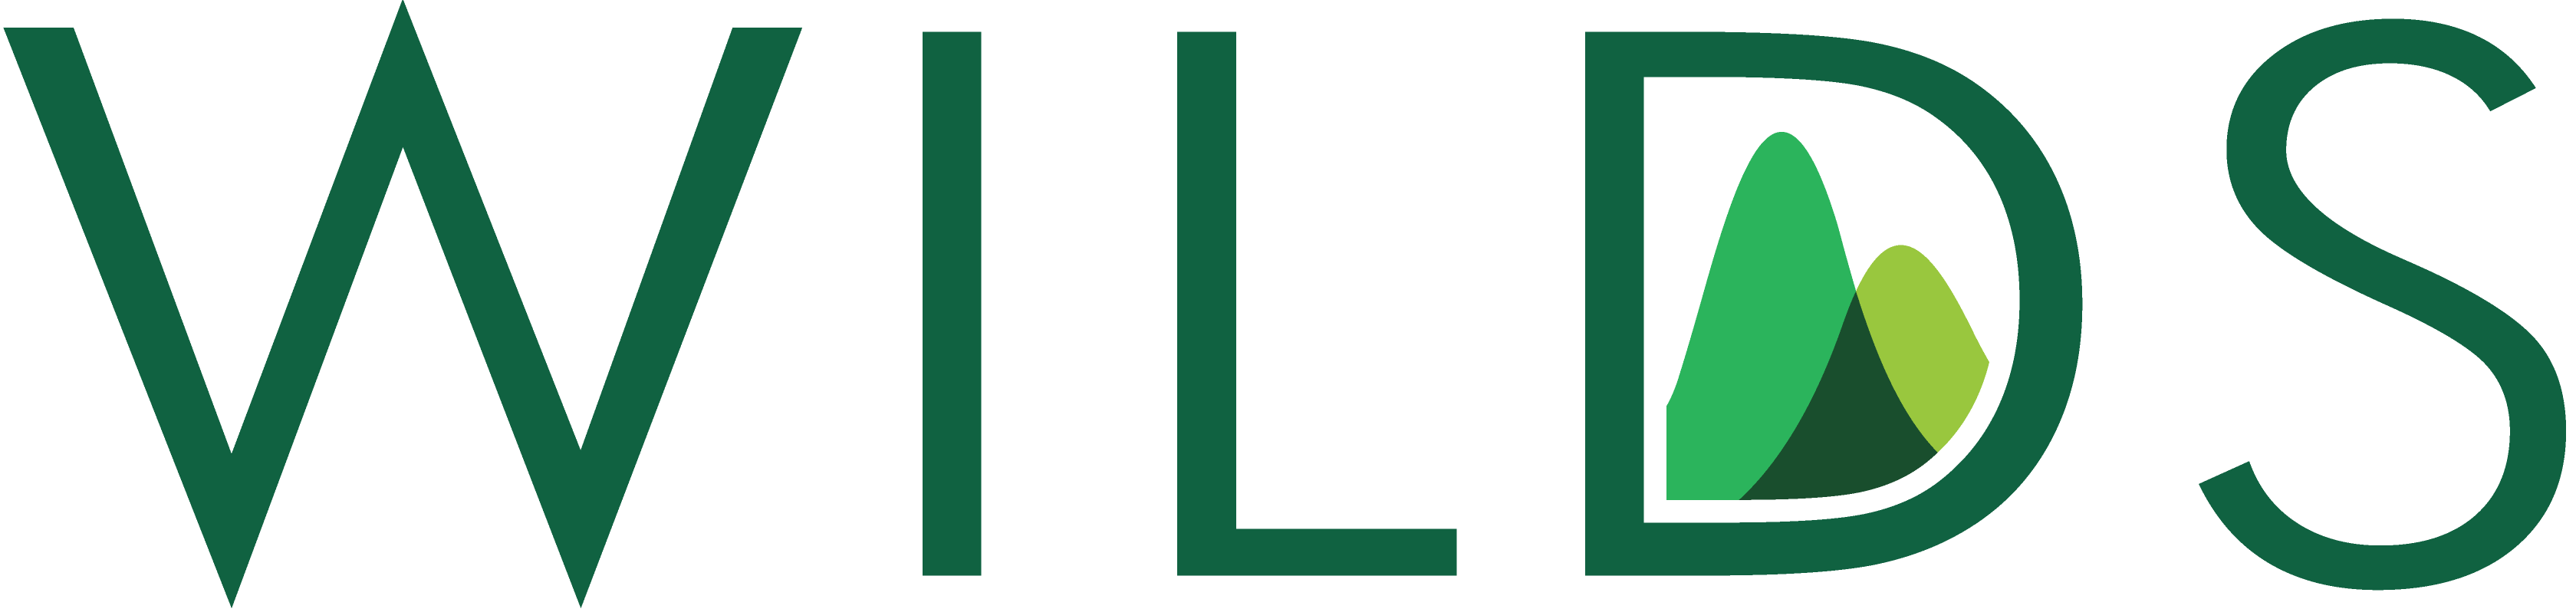
- WILDS (https://github.com/p-lambda/wilds) is a PyTorch-based library for distribution shifts. It contains data loaders and evaluation functions for the Global Wheat Competition, as well as some examples of algorithms and models that you can build on.
- The goal of this notebook is to help you get started with using the WILDS library to train and submit your first model! 
- Using WILDS is not necessary for participating in the competition. However, you might find a lot of the utilities and infrastructure in the WILDS library useful.
- Before starting, please check in Edit / Notebook settings that "GPU" is selected


## Download Aicrowd-cli 📚

The Aicrowd CLI enables making submissions directly via the notebook.

In [ ]:
!pip install aicrowd-cli

     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 204kB 16.5MB/s 
     |████████████████████████████████| 174kB 49.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 92kB 11.3MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 71kB 10.6MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installation: click 8.

In [ ]:
### Please enter your API Key from [here](https://www.aicrowd.com/participants/me).
API_KEY = "" 
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


## Download the WILDS library

For more detailed installation instructions, please refer to the WILDS [documentation](https://github.com/p-lambda/wilds).


In [ ]:
!pip uninstall torch torchvision torchaudio -y
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!git clone https://github.com/p-lambda/wilds/

!cd wilds && git checkout dev && pip install -e .
!pip install transformers

Uninstalling torch-1.8.1+cu101:
  Successfully uninstalled torch-1.8.1+cu101
Uninstalling torchvision-0.9.1+cu101:
  Successfully uninstalled torchvision-0.9.1+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 24kB/s 
     |████████████████████████████████| 12.8MB 264kB/s 
     |████████████████████████████████| 7.6MB 17.8MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1+cu101 which is incompatible.
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
     |████████████████████████████████| 2.8MB 11.9MB/s 
Cloning into 'wilds'...
remote: Enumerating objects: 2835, done.
remote: Counting objects: 100% (517/517), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 2835 (delta 437), reused 435 (delta 396), pack-reused 2318
Receiving objects: 100% (2835/2835), 695.00 KiB | 23.17 MiB/s, done.
Resolving deltas: 100% (2114/2114), done.
Branch '

## Run the WILDS package

This sample command will train a FasterRCNN model with the [Group DRO](https://arxiv.org/abs/1911.08731) algorithm that tries to minimize the loss of the worst-case training domain. 

To train using a different algorithm like standard empirical risk minimization (ERM), simply replace `--algorithm groupDRO` with `--algorithm ERM`.

WILDS will automatically handle downloading the Global Wheat Competition dataset to the location specified in `root_dir`. For the purposes of this competition, both the val and the test sets in the WILDS library do not have labels provided, so the reported val and test accuracies are just dummy values.



In [ ]:
N_EPOCHS=10
SAVE_TO="gdro"

In [ ]:
!python3 wilds/examples/run_expt.py -d gwhd --algorithm groupDRO --root_dir data --log_dir $SAVE_TO --download --progress_bar --save_step 1 --split_scheme official --n_epochs $N_EPOCHS

2021-05-17 06:49:23.673279: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Dataset: gwhd
Algorithm: groupDRO
Root dir: data
Split scheme: official
Dataset kwargs: {}
Download: True
Frac: 1.0
Version: None
Loader kwargs: {'num_workers': 1, 'pin_memory': True}
Train loader: standard
Uniform over groups: True
Distinct groups: True
N groups per batch: 4
Batch size: 4
Eval loader: standard
Model: fasterrcnn
Model kwargs: {'n_classes': 1, 'pretrained': True, 'pretrained_model': True, 'pretrained_backbone': True, 'min_size': 1024, 'max_size': 1024}
Train transform: image_base
Eval transform: image_base
Target resolution: None
Resize scale: None
Max token length: None
Loss function: fasterrcnn_criterion
Loss kwargs: {}
Groupby fields: ['location_date_sensor']
Group dro step size: 0.01
Coral penalty weight: None
Irm lambda: None
Irm penalty anneal iters: None
Algo log metric: None
Val metric: detection_acc_avg
Val metric dec

# Preparing a submission
The WILDS library saves predictions in `*_pred.pth` files. To prepare them for submission to our competition, we have to transform them into the appropriate format.

In [ ]:
import torch
import pandas as pd

pred_false_val = torch.load(f"{SAVE_TO}/gwhd_split:val_seed:{N_EPOCHS-1}_epoch:{N_EPOCHS-1}_pred.pth")
pred_false_test = torch.load(f"{SAVE_TO}/gwhd_split:test_seed:{N_EPOCHS-1}_epoch:{N_EPOCHS-1}_pred.pth")

false_val = pd.read_csv("data/gwhd_v0.9/official_val.csv") 
false_test = pd.read_csv("data/gwhd_v0.9/official_test.csv") 

In [ ]:
assert len(false_val) == len(pred_false_val)
assert len(pred_false_test) == len(pred_false_test)

In [ ]:
def encodeBoxes(tensor_boxes,score_thr=0.5):
  boxes = tensor_boxes["boxes"].numpy()
  scores = tensor_boxes["scores"].numpy()
  boxes = boxes[scores > score_thr]

  strboxes = ";".join([" ".join([str(int(i)) for i in box]) for box in boxes])

  if len(strboxes) == 0:
    strboxes = "no_box"
  
  return strboxes

In [ ]:
encoded_boxes = [encodeBoxes(tensor_boxes) for tensor_boxes in pred_false_val]
false_val["PredString"] = encoded_boxes
encoded_boxes = [encodeBoxes(tensor_boxes) for tensor_boxes in pred_false_test]
false_test["PredString"] = encoded_boxes


## Sanity check before submission

> We can check few predictions to get an idea of how well the training went

In [ ]:
test_img = "data/gwhd_v0.9/images/"+ false_test["image_name"].values[1]
print(test_img)
import cv2
import matplotlib.pyplot as plt
test_img = cv2.imread(test_img)
boxes = pred_false_test[1]["boxes"].numpy()
scores = pred_false_test[1]["scores"].numpy()

boxes = boxes[scores >0.5] # we set a naive threshold here 

for (x,y,xx,yy) in boxes:
  cv2.rectangle(test_img,(int(x),int(y)),(int(xx),int(yy)),(255,0,0),5)

plt.imshow(test_img[...,::-1])

## Writing submission file

In [ ]:
results = pd.concat([false_test,false_val]) #Val and test does not correspond to the true split
del results["BoxesString"] # We need to remove this column or it causes damage :)
results["image_name"] = results["image_name"].apply(lambda x: x.replace(".png","")) # we need to remove the extension
results.to_csv("submission_final.csv",index=False)


## Making Direct Submission thought Aicrowd CLI

In [ ]:
!aicrowd submission create -c global-wheat-challenge-2021 -f submission_final.csv